In [1]:
!pip install -q numpy matplotlib scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

In [3]:
import json
from collections import defaultdict, Counter

class InvertedIndex:
    def __init__(self):
        self.postings = defaultdict(dict)
        self.docs = {}
        self.my_collection = []

    def add_document(self, doc_id, tokens, metadata=None):
        freq = Counter(tokens)
        for tok, cnt in freq.items():
            self.postings[tok][doc_id] = cnt
        if metadata is None:
            metadata = {}
        self.docs[doc_id] = metadata

    def save(self, filepath="/kaggle/input/index-file/index.json"):
        out = {'postings': {}, 'docs': self.docs}
        for tok, m in self.postings.items():
            out['postings'][tok] = m
        with open(filepath, 'w', encoding='utf-8') as f:
            json.dump(out, f, ensure_ascii=False, indent=2)

    def load(self, filepath="/kaggle/input/index-file/index.json"):
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        self.postings = {k: v for k, v in data.get('postings', {}).items()}
        self.docs = data.get('docs', {})

    def get_postings(self, token):
        return self.postings.get(token, {})


In [4]:
def build_tfidf_matrix(index):
    vocab = list(index.postings.keys())
    vocab_index = {tok: i for i, tok in enumerate(vocab)}
    
    doc_ids = list(index.docs.keys())
    doc_index = {doc_id: i for i, doc_id in enumerate(doc_ids)}
    
    tf_matrix = np.zeros((len(doc_ids), len(vocab)), dtype=float)
    
    for tok, postings in index.postings.items():
        for doc_id, freq in postings.items():
            tf_matrix[doc_index[doc_id], vocab_index[tok]] = freq

    df = np.count_nonzero(tf_matrix > 0, axis=0)
    idf = np.log((1 + len(doc_ids)) / (1 + df)) + 1
    tfidf = tf_matrix * idf
    tfidf = normalize(tfidf, norm='l2', axis=1)

    return tfidf, doc_ids, vocab



def get_collection_tfidf(index):
    all_tfidf, all_doc_ids, vocab = build_tfidf_matrix(index)

    doc_indices = [all_doc_ids.index(doc_id) for doc_id in index.my_collection if doc_id in all_doc_ids]
    tfidf_subset = all_tfidf[doc_indices, :]
    selected_docs = [all_doc_ids[i] for i in doc_indices]
    
    return tfidf_subset, selected_docs, vocab




def cluster_documents(tfidf_matrix, doc_ids, n_clusters=5, index=None,  top_50=False):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(tfidf_matrix)

    if not top_50:
        print("\nDocument Clustering Results:")
        for doc_id, label in zip(doc_ids, labels):
            print(f"  Document {doc_id} → Cluster {label} -> {index.docs[doc_id]['url']}")

    return labels

In [5]:
index = InvertedIndex()
index.load("/kaggle/input/index-file/index.json")

docs_sustainability = index.get_postings("sustainability")
docs_waste = index.get_postings("waste")

n_sustainability = len(docs_sustainability)
n_waste = len(docs_waste)
overlap = len(set(docs_sustainability) & set(docs_waste))

print(f"Documents for 'sustainability': {n_sustainability} - {docs_sustainability}")
print(f"Documents for 'waste': {n_waste} - {docs_waste}")
print(f"Documents in both: {overlap} - {set(docs_sustainability) & set(docs_waste)}")

index.my_collection = list(set(docs_sustainability) | set(docs_waste))
print(f"Total unique documents in My-collection: {len(index.my_collection)} - {index.my_collection}")

Documents for 'sustainability': 131 - {'51': 1, '55': 6, '56': 6, '57': 1, '60': 3, '67': 4, '69': 5, '74': 2, '78': 3, '80': 1, '91': 1, '93': 5, '94': 9, '97': 2, '104': 5, '110': 1, '461': 1, '585': 1, '672': 1, '851': 1, '874': 1, '881': 1, '1058': 1, '1189': 1, '1222': 1, '1327': 1, '1392': 1, '1642': 2, '1650': 1, '1653': 7, '1692': 1, '1732': 2, '1733': 1, '1734': 2, '1748': 3, '1749': 1, '1751': 3, '1755': 1, '1759': 1, '1760': 2, '1763': 1, '1766': 2, '1768': 1, '1775': 2, '1781': 1, '1782': 1, '1863': 1, '1876': 2, '1894': 1, '1927': 1, '1930': 3, '2008': 1, '2010': 1, '2022': 1, '2027': 1, '2035': 3, '2038': 1, '2049': 1, '2053': 1, '2057': 1, '2058': 1, '2408': 2, '2456': 2, '2685': 1, '2763': 1, '2826': 6, '3019': 6, '3072': 1, '3078': 8, '3082': 18, '3090': 16, '3135': 6, '3136': 12, '3144': 1, '3160': 1, '3178': 2, '3183': 3, '3248': 2, '3281': 24, '3309': 2, '3341': 2, '3376': 15, '3393': 9, '3450': 1, '3456': 2, '3463': 8, '3474': 1, '3506': 2, '3550': 4, '3568': 1, '3

In [6]:
def plot_clusters(tfidf_matrix, labels, k, val): 
    reducer = PCA(n_components=2, random_state=42) 
    reduced = reducer.fit_transform(tfidf_matrix) 
    plt.figure(figsize=(5, 5)) 
    plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=50) 
    plt.title(f'K={k} for {val}') 
    plt.xlabel('Component 1') 
    plt.ylabel('Component 2') 
    plt.colorbar(label='Cluster ID') 
    plt.show()

In [7]:
tfidf, doc_ids, vocab = get_collection_tfidf(index)
all_tfidf, all_doc_ids, vocab = build_tfidf_matrix(index)

In [9]:
for k in [2,10,20]:
    print(f"Clustering with K={k}")
    labels = cluster_documents(tfidf, doc_ids, n_clusters=k, index=index)

Clustering with K=2


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Document Clustering Results:
  Document 1749 → Cluster 1 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/2025.html
  Document 3759 → Cluster 0 -> https://spectrum.library.concordia.ca/id/eprint/990129/
  Document 3878 → Cluster 0 -> https://spectrum.library.concordia.ca/id/eprint/988663/
  Document 3568 → Cluster 0 -> https://spectrum.library.concordia.ca/id/eprint/991183/
  Document 1742 → Cluster 1 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/2010.html
  Document 1764 → Cluster 1 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/1981.html
  Document 4306 → Cluster 0 -> https://spectrum.library.concordia.ca/id/eprint/988917/
  Document 56 → Cluster 1 -> https://spectrum.library.concordia.ca/view/year/2021.html
  Document 3072 → Cluster 0 -> https://spectrum.library.concordia.ca/id/eprint/988621/
  Document 3937 → Cluster 0 -> https://spectrum.library.concordia.ca/id/eprint/988956/
  Docum

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Document Clustering Results:
  Document 1749 → Cluster 7 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/2025.html
  Document 3759 → Cluster 4 -> https://spectrum.library.concordia.ca/id/eprint/990129/
  Document 3878 → Cluster 4 -> https://spectrum.library.concordia.ca/id/eprint/988663/
  Document 3568 → Cluster 4 -> https://spectrum.library.concordia.ca/id/eprint/991183/
  Document 1742 → Cluster 7 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/2010.html
  Document 1764 → Cluster 7 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/1981.html
  Document 4306 → Cluster 3 -> https://spectrum.library.concordia.ca/id/eprint/988917/
  Document 56 → Cluster 5 -> https://spectrum.library.concordia.ca/view/year/2021.html
  Document 3072 → Cluster 4 -> https://spectrum.library.concordia.ca/id/eprint/988621/
  Document 3937 → Cluster 4 -> https://spectrum.library.concordia.ca/id/eprint/988956/
  Docum

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Document Clustering Results:
  Document 1749 → Cluster 3 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/2025.html
  Document 3759 → Cluster 10 -> https://spectrum.library.concordia.ca/id/eprint/990129/
  Document 3878 → Cluster 4 -> https://spectrum.library.concordia.ca/id/eprint/988663/
  Document 3568 → Cluster 10 -> https://spectrum.library.concordia.ca/id/eprint/991183/
  Document 1742 → Cluster 3 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/2010.html
  Document 1764 → Cluster 16 -> https://spectrum.library.concordia.ca/view/document_subtype/thesis=5Fmasters/1981.html
  Document 4306 → Cluster 7 -> https://spectrum.library.concordia.ca/id/eprint/988917/
  Document 56 → Cluster 14 -> https://spectrum.library.concordia.ca/view/year/2021.html
  Document 3072 → Cluster 10 -> https://spectrum.library.concordia.ca/id/eprint/988621/
  Document 3937 → Cluster 10 -> https://spectrum.library.concordia.ca/id/eprint/988956/
 

Clustering with K=2


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


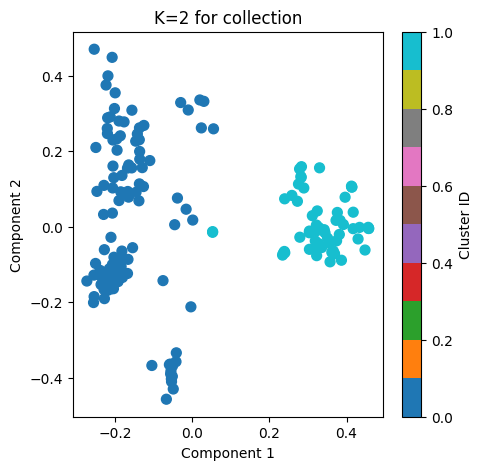

Clustering with K=10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


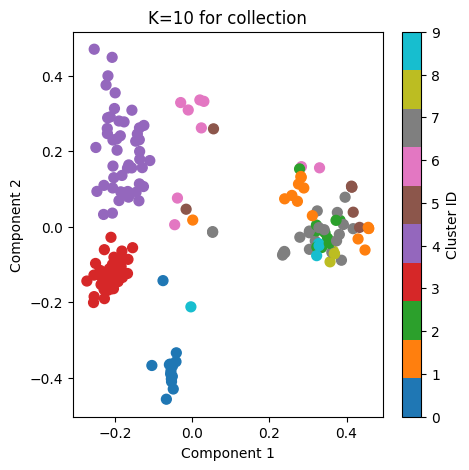

Clustering with K=20


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


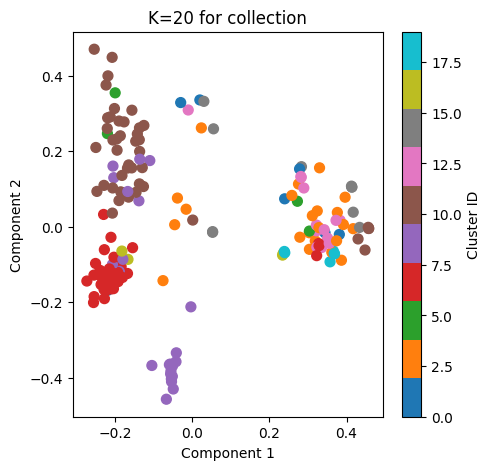

In [11]:
for k in [2,10,20]:
    print(f"Clustering with K={k}")
    labels = cluster_documents(tfidf, doc_ids, n_clusters=k, index=index,top_50=True)
    plot_clusters(tfidf, labels, k, "collection")

Clustering with K=2


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


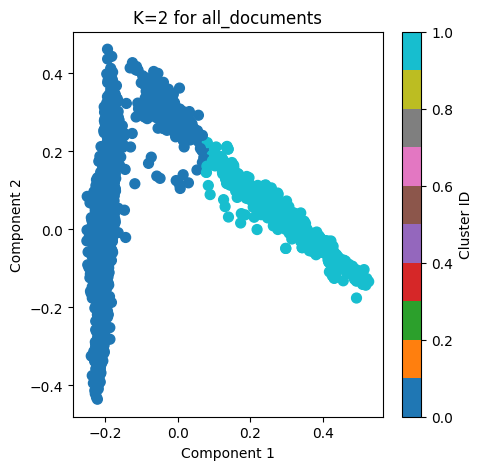

Clustering with K=10


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


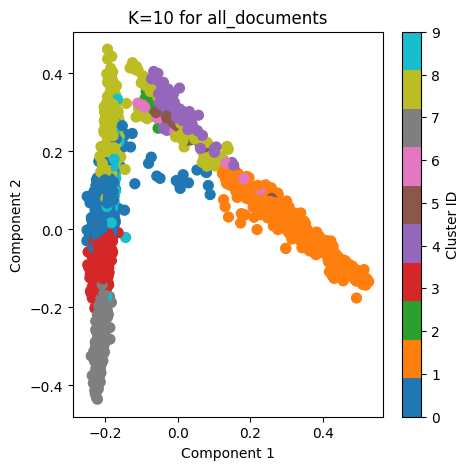

Clustering with K=20


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


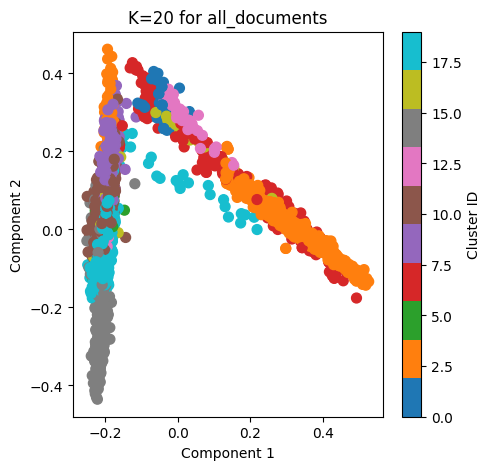

In [9]:
for k in [2,10,20]:
    print(f"Clustering with K={k}")
    labels_for_all  = cluster_documents(all_tfidf, all_doc_ids, n_clusters=k, index=index,top_50=True)
    plot_clusters(all_tfidf, labels_for_all, k, "all_documents")

In [8]:
def top_50_tfidf(tfidf_matrix, labels, index):
    vocab = list(index.postings.keys())
    n_clusters = len(set(labels))
    print("\nTop 50 words per cluster (by TF-IDF)")

    for cluster_id in range(n_clusters):
        cluster_indices = np.where(labels == cluster_id)[0]
        
        if len(cluster_indices) == 0:
            print(f"\nCluster {cluster_id} is empty.")
            continue
        
        cluster_tfidf = tfidf_matrix[cluster_indices].mean(axis=0)
        
        top_indices = np.argsort(-cluster_tfidf)[:50]
        top_words = [(vocab[i], cluster_tfidf[i]) for i in top_indices]

        print(f"\nCluster {cluster_id} ({len(cluster_indices)} docs):")
        for word, score in top_words:
            print(f"  {word:20s}  TF-IDF={score:.4f}")

In [9]:
for k in [2,10,20]:
    print(f"\nClustering with K={k}")
    labels = cluster_documents(tfidf, doc_ids, n_clusters=k, index=index, top_50=True)
    top_50_tfidf(tfidf, labels, index)


Clustering with K=2


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Top 50 words per cluster (by TF-IDF)

Cluster 0 (120 docs):
  and                   TF-IDF=0.1447
  of                    TF-IDF=0.1417
  the                   TF-IDF=0.1338
  a                     TF-IDF=0.0790
  concordia             TF-IDF=0.0658
  in                    TF-IDF=0.0645
  to                    TF-IDF=0.0637
  spectrum              TF-IDF=0.0612
  hide                  TF-IDF=0.0612
  var                   TF-IDF=0.0574
  function              TF-IDF=0.0569
  jquery                TF-IDF=0.0525
  on                    TF-IDF=0.0522
  j                     TF-IDF=0.0474
  energy                TF-IDF=0.0439
  bs                    TF-IDF=0.0437
  element               TF-IDF=0.0427
  https                 TF-IDF=0.0423
  for                   TF-IDF=0.0411
  doi                   TF-IDF=0.0405
  sustainability        TF-IDF=0.0392
  library               TF-IDF=0.0369
  10                    TF-IDF=0.0366
  by                    TF-IDF=0.0365
  isbootstrapevent      TF-

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Top 50 words per cluster (by TF-IDF)

Cluster 0 (1 docs):
  biodegradation        TF-IDF=0.3366
  benzene               TF-IDF=0.2321
  oil                   TF-IDF=0.2174
  of                    TF-IDF=0.2061
  transport             TF-IDF=0.1979
  aquifer               TF-IDF=0.1848
  boufadel              TF-IDF=0.1721
  groundwater           TF-IDF=0.1690
  beach                 TF-IDF=0.1508
  spill                 TF-IDF=0.1431
  mc                    TF-IDF=0.1357
  water                 TF-IDF=0.1355
  the                   TF-IDF=0.1354
  petroleum             TF-IDF=0.1315
  and                   TF-IDF=0.1280
  in                    TF-IDF=0.1207
  hydrology             TF-IDF=0.1179
  environmental         TF-IDF=0.1101
  contaminant           TF-IDF=0.1044
  tidal                 TF-IDF=0.1036
  fate                  TF-IDF=0.1008
  coastal               TF-IDF=0.1008
  plume                 TF-IDF=0.0968
  shoreline             TF-IDF=0.0968
  aquifers              TF-ID

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Top 50 words per cluster (by TF-IDF)

Cluster 0 (6 docs):
  and                   TF-IDF=0.2348
  of                    TF-IDF=0.1863
  construction          TF-IDF=0.1841
  the                   TF-IDF=0.1213
  journal               TF-IDF=0.1190
  a                     TF-IDF=0.0969
  j                     TF-IDF=0.0929
  management            TF-IDF=0.0915
  in                    TF-IDF=0.0858
  elsevier              TF-IDF=0.0773
  maintenance           TF-IDF=0.0770
  bim                   TF-IDF=0.0739
  pages                 TF-IDF=0.0721
  seismic               TF-IDF=0.0678
  m                     TF-IDF=0.0631
  h                     TF-IDF=0.0603
  for                   TF-IDF=0.0592
  building              TF-IDF=0.0571
  international         TF-IDF=0.0569
  biodegradation        TF-IDF=0.0561
  p                     TF-IDF=0.0557
  based                 TF-IDF=0.0556
  ontology              TF-IDF=0.0538
  simulation            TF-IDF=0.0526
  facilities            TF-ID